---

In [58]:
# libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import itertools
import scipy
import matplotlib as mpl


from scipy.integrate import quad as integrate
from scipy.integrate import simps as simps
from scipy import interpolate as interp

from numpy.random import normal
from scipy.stats import norm


from random import randrange


from tqdm.notebook import tqdm

from itertools import product

from scipy.interpolate import interp1d

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

---



$$dX_t  \: =   \: \mu(t)X_t \: dt \:+\: \sigma(t) \:dW_t , \qquad X_0= x_0$$

In [60]:
# funs 
def EulerMaruyama_approx_sol(N, mu, sigma, x0,ax):
    """
    Returns discrete numerical approximation of stochastic process solving an SDE of the form
            dX(t) =  b(t)X(t) dt + c(t)dW(t) 
    by approximating the continous solution X(t) by random variables 
    X_n = X(t_n) where t_n = n∆t, n = 0,1,2, and ∆t = 1/N

    Parameters
    ----------
    N : int
        Discretisation of [0,1] interval. Determines step size ∆t = 1/N
    mu : function
        Drift of SDE, takes (x, t) as input
    sigma : function
        Diffusion of SDE, takes (x, t) as input 
    x0 : float
        Starting point of solution

    Returns
    ----------
    X : array(float) np.array of size N
    """ 
    
    t = np.linspace(0,1,N)
    X = np.zeros(N)
    
    X[0] = x0
    dt = 1/N
    
    for i in range(N-1):
        dX = X[i]*mu(t[i])*dt + sigma(t[i])*normal()*np.sqrt(dt)
        X[i+1] = X[i] + dX
    ax.plot(t,X,lw=1,alpha=.3)
    return X

def generate_sparse_obs__forScores(n, r, dt, mu, sigma, x0, N, sigma_noise ):
    N = int(dt**(-1)) 
    X = []; T = []; Y = []; C = []
    fig,ax = plt.subplots(figsize =(20,3))
    for i in (range(n)):
        X_i = EulerMaruyama_approx_sol(N = N, mu= mu , sigma=sigma, x0 = x0, ax=ax); X.append(X_i)
        T_i = []; Y_i = []
        for j in range(r):
            random_input = randrange(N)
            T_ij = random_input/N
            Y_ij = X_i[random_input] + np.random.normal(scale = sigma_noise)
            Y_i.append(Y_ij); T_i.append(T_ij)
        Y.append(np.array([Y_i[j] for j in np.argsort(T_i)]))  
        T.append(np.array([T_i[j] for j in np.argsort(T_i)]))
    X = np.array(X); T = np.array(T); Y = np.array(Y)
    return T,Y       

def univariate_local_linear_smoothing(T,Y,K,h):
    r = Y.shape[1]; n  = Y.shape[0]; _nr = n*r
    T = T.reshape(-1); Y = Y.reshape(-1)
    K_h = lambda t: K(t/h)/h   
    cali_T = lambda t0 : np.array( [ ( (T - t0) )**p for p in [0,1] ] ).T
    bold_W = lambda t0 : np.diag(np.array([K_h(_t - t0) for _t in T]))
    def minimizers(t0):
        try:
            res =  np.linalg.inv(  cali_T(t0).T @ bold_W(t0) @ cali_T(t0) )  @ cali_T(t0).T @  bold_W(t0) @  Y 
        except:
            res =   np.linalg.pinv(  cali_T(t0).T @ bold_W(t0) @ cali_T(t0) )@ cali_T(t0).T @  bold_W(t0) @  Y 
        return  res
    return lambda t0: minimizers(t0)
          
def bivariate_local_linear_smoothing_triangular(T,Y,K,h, bias = True):
    r = Y.shape[1]; n  = Y.shape[0]
    if bias is True:
        upper_triangular_pairs = set(
            pair for pair in zip(*np.triu_indices(r))).difference(set(zip(np.arange(r),np.arange(r))))
    else:
        upper_triangular_pairs = set(pair for pair in zip(*np.triu_indices(r)))

    utp_T = [(T_i[j], T_i[k]) for (j,k) in upper_triangular_pairs for T_i in T ]
    utp_Y = [(Y_i[j], Y_i[k]) for (j,k) in upper_triangular_pairs for Y_i in Y ]

    Kh = lambda t: K(t/h)/h

    caliK = lambda s,t : np.diag( np.array([ Kh(T_ij-s)*Kh(T_ik-t) for (T_ij, T_ik) in utp_T ]))

    caliY = np.array([ Y_ij*Y_ik for (Y_ij, Y_ik) in utp_Y ]) 

    caliX = lambda s,t : np.array([ np.array([ 1, T_ij - s, T_ik - t ]) for (T_ij, T_ik) in utp_T ]) 
    
    def minimizers(s,t):
        _caliX = caliX(s,t); _caliK = caliK(s,t); _caliY = caliY; XtransposeK =  _caliX.T @ _caliK

        try:
            res = np.linalg.inv(  XtransposeK @ _caliX) @ XtransposeK @ _caliY
        except:
            res = np.linalg.pinv(  XtransposeK @ _caliX) @ XtransposeK @ _caliY
        return  res

    return lambda s,t : minimizers(min(s,t), max(s,t))

def bivariate_local_linear_smoothing_triangular_exp(T,Y,K,h, bias = True):
    
    Kh = lambda t: K(t/h)/h
    def Khp(p):
        return lambda t: (t/h)**p*Kh(t)
    
    if bias is True:
        upper_triangular_pairs = set(
            pair for pair in zip(*np.triu_indices(r))).difference(set(zip(np.arange(r),np.arange(r))))
    else:
        upper_triangular_pairs = set(pair for pair in zip(*np.triu_indices(r)))

   
    def a0_a1_a2(s,t):
        def Ap(p1,p2):
            return lambda s,t : np.array([ Khp(p1)(s - T_i[j])*Khp(p2)(t - T_i[k])
                                    for (j,k) in upper_triangular_pairs for T_i in T ]).sum()
        def Sp(p1,p2):
            return lambda s,t : np.array([ Khp(p1)( s - T_i[ j ] )  *  Khp(p2)( t - T_i[ k ]  )\
                                  *( Y_i[j] * Y_i[ k ] )
                                    for (j,k) in upper_triangular_pairs for T_i,Y_i in zip(T,Y) ]).sum()

        S_00 = Sp(0,0)(s,t)
        S_01 = Sp(0,1)(s,t)
        S_10 = Sp(1,0)(s,t)
        A_00 = Ap(0,0)(s,t)
        A_10 = Ap(1,0)(s,t)
        A_01 = Ap(0,1)(s,t)
        A_11 = Ap(1,1)(s,t)
        A_20 = Ap(2,0)(s,t)
        A_02 = Ap(0,2)(s,t)
        calM_1 =  A_20 * A_02 - A_11**2
        calM_2 =  - A_10 * A_02 + A_01*A_11
        calM_3 =  A_10 * A_11 - A_01*A_20
        determinant = calM_1*A_00 + calM_2*A_10 + calM_3*A_01
        a0 = (calM_1*S_00 + calM_2*S_10 + calM_3*S_01) / determinant
        calM_1 =  - A_10 * A_02 + A_01*A_11
        calM_2 =  A_00 * A_02 - A_01*A_01
        calM_3 =  - A_00 * A_11 + A_01*A_01
        a1 = (calM_1*S_00 + calM_2*S_10 + calM_3*S_01) / determinant
        calM_1 =  A_10 * A_11 - A_01*A_20
        calM_2 =  - A_00 * A_11 + A_01*A_10
        calM_3 =  A_00 * A_20 - A_10*A_01
        a2 = (calM_1*S_00 + calM_2*S_10 + calM_3*S_01) / determinant
        return a0, a1, a2
    return lambda s,t : a0_a1_a2(min(s,t),max(s,t))

def get_mu(m,dm):
    return lambda t : dm(t)*(m(t))**(-1)

def get_sigma2_DIAGONAL_fromFull(_m, _dm, _G, _D1_G, _D2_G, _mu):
    N = _m.size
    time_grid = np.linspace(0,1,N)
    def res(t):
        t_ix = np.argmin((t-time_grid)**2)
        return (np.diagonal(_D1_G + _D2_G) - 2*_m*_dm  - 2*_mu*(np.diagonal(_G) - _m**2))[t_ix]   
    
    return lambda t : res(t)

def get_sigma2_DIAGONAL_fromDiag(_m, _dm, _diag_G, _diag_dG, _mu):
    N = _m.size
    time_grid = np.linspace(0,1,N)
    def res(t):
        t_ix = np.argmin((t-time_grid)**2)
        return (_diag_dG - 2*_m*_dm  - 2*_mu*(_diag_G - _m**2))[t_ix]   

    return lambda t : res(t)

def get_sigma2_TRIANGULAR(_m, _dm, _G, _D1_G, _b):

    N = _m.size
    time_grid = np.linspace(0,1,N)
    def res(s):
#         s_ix = max( 0, np.argmin((s-time_grid)**2)-1)
        s_ix = np.argmin((s- 0.021 -time_grid)**2)
            
        def second(s_ix,t_ix):
            return simps(_b[s_ix : t_ix+1]*_D1_G[s_ix, s_ix : t_ix+1], time_grid[s_ix: t_ix+1]  )
        
        return np.array(
                [ _D1_G[s_ix, t_ix ] - _b[s_ix]*_G[s_ix, s_ix ] - second(s_ix,t_ix)
                  for t_ix in np.arange(s_ix, time_grid.size-1)     ]).mean()

    return lambda s : res(s)



---

# Model

In [135]:
mu = lambda t :  0.2+0.8*np.sin(2*np.pi*t)
sigma = lambda t : 1


In [136]:

# x0 
x0 = 1

In [137]:
# discretization of unit interval for estimation evaluation 
N = 50
time_grid = np.linspace(0,1,N)

##### Generate samples

In [138]:
# number of sampled curves
n = 30

In [168]:
#number of observations per curve
r = 5

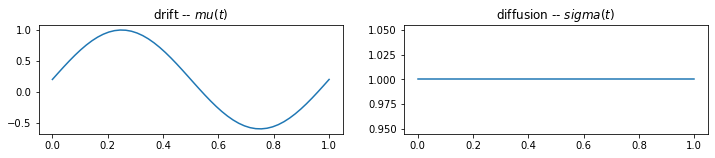

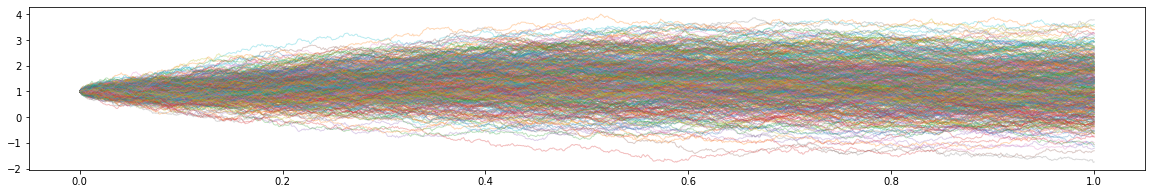

In [169]:
# step size of Euler-Maruyama approximation method


fig, [axL,axR] = plt.subplots(figsize = (12,2), ncols = 2)
axL.plot(time_grid, [mu(t) for t in time_grid])
axL.set_title('drift -- $mu(t)$')
axR.plot(time_grid, [sigma(t) for t in time_grid])
axR.set_title('diffusion -- $sigma(t)$')
plt.show()


dt = 1e-3
T,Y = generate_sparse_obs__forScores(n, r, dt, mu, sigma,x0,N, sigma_noise = 0)


---

----

# Estimation

In [170]:
# bandwith parameter
h = (r*n)**(-1/5)

##### m estimation

In [171]:
# m 


# smoothing kernel
K = lambda x : 3/4*(1-x**2) if  3/4*(1-x**2) > 0 else 0

# python functions corresponding to the estimated mean and derivative
m_hat = lambda t : univariate_local_linear_smoothing(T, Y, K, h)(t)[0]
dm_hat = lambda t : univariate_local_linear_smoothing(T, Y, K, h)(t)[1]

# np array of estimated functions evaluations on discretized unit interval
_M_ = np.array([univariate_local_linear_smoothing(T, Y, K, h)(t) for t in tqdm(time_grid)])
MHAT = _M_[:,0]
dMHAT = _M_[:,1]


##### G estimation

In [172]:
# G 

# smoothing kernel
K = lambda x : 3/4*(1-x**2) if  3/4*(1-x**2) > 0 else 0


# python functions corresponding to the estimated second moment function and its partial derivatives
G_hat = lambda s,t : bivariate_local_linear_smoothing_triangular_nobias(T,Y,K,h)(s,t)[0]
D1_G_hat = lambda s,t : bivariate_local_linear_smoothing_triangular_nobias(T,Y,K,h)(s,t)[1]
D2_G_hat = lambda s,t : bivariate_local_linear_smoothing_triangular_nobias(T,Y,K,h)(s,t)[2]

# np array of estimated functions evaluations on discretized unit square
GHAT, D1GHAT, D2GHAT = np.zeros(shape = (N,N)), np.zeros(shape = (N,N)), np.zeros(shape = (N,N))
for i,s in tqdm(zip(np.arange(N),time_grid), total = N):
    for j,t in zip(np.arange(i,N),time_grid[i:]):
        _G_ =  bivariate_local_linear_smoothing_triangular(T,Y,K,h)(s,t).reshape(-1)
        GHAT[i,j] = _G_[0]; GHAT[j,i] = _G_[0]
        D1GHAT[i,j] = _G_[1]; D1GHAT[j,i] = _G_[1]
        D2GHAT[i,j] = _G_[2]; D2GHAT[j,i] = _G_[2]

# ... and on the diagonal       
GDIAGHAT = np.diagonal(GHAT)
D1GDIAGHAT = np.diagonal(D1GHAT)
D2GDIAGHAT = np.diagonal(D2GHAT)

dGDIAGHAT = np.diagonal(D1GHAT + D2GHAT)
GDIAGHAT = np.diagonal(GHAT)


In [173]:
# diag_G_ 
_diag_G_ = np.array([univariate_local_linear_smoothing(T, Y**2, K, h)(t) for t in tqdm(time_grid)])
diag_GHAT = _diag_G_[:,0]
diag_dGHAT = _diag_G_[:,1]


---

# Evaluation

##  Mean:  $\mathbb{E}X_t$

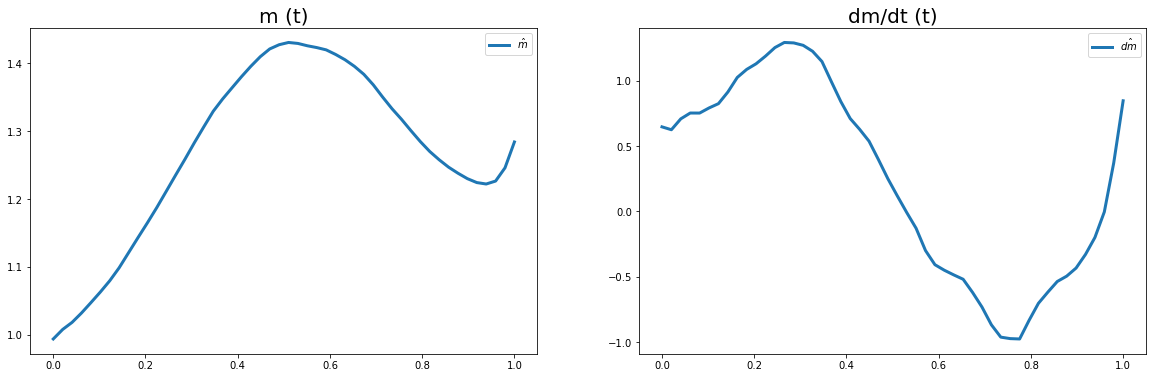

In [174]:
# plot 
fig, [axl, axr] = plt.subplots( figsize = (20,6), ncols=2)


axl.set_title("m (t)", fontsize=20)
axl.plot(time_grid, 
         MHAT,
         label ='$\hat m$', lw=3)

axl.legend()



axr.set_title('dm/dt (t)', fontsize=20)
axr.plot(time_grid, 
         dMHAT,
         label ='$\hat {dm}$', lw=3)

axr.legend()

plt.show()




----

## 2nd moment : $G(s,t) =    \mathbb{E}X_tX_s$

### Diagonal

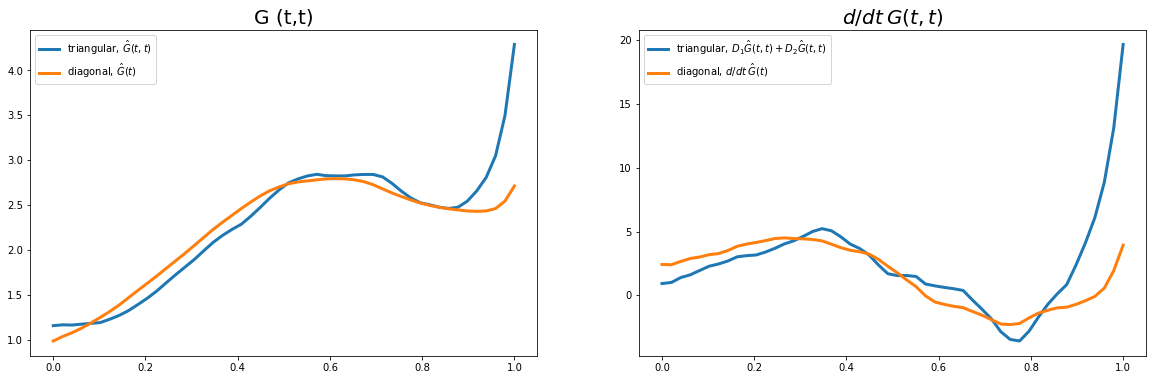

In [175]:
# plot 
fig, [axl, axr] = plt.subplots( figsize = (20,6), ncols=2)

axl.set_title("G (t,t)", fontsize=20)


axl.plot(time_grid, 
         GDIAGHAT,
         label ='triangular, $\hat G(t,t)$', lw=3)

axl.plot(time_grid, 
         diag_GHAT,
         label ='diagonal, $\hat G(t)$', lw=3)



axl.legend()


### Derivative

# plot:  sum of partial derivatives of G as bivariate fun & of derivative of G on diagonal: true vs estimated

axr.set_title("$d/dt \: G(t,t)$", fontsize=20)



axr.plot(time_grid, 
         D1GDIAGHAT + D2GDIAGHAT,
         label ='triangular, $D_1\hat G(t,t) + D_2 \hat G(t,t)$',
         lw=3)

axr.plot(time_grid, 
         diag_dGHAT,
         label ='diagonal, $d/dt \: \hat G(t)$',
         lw=3)


axr.legend()




### Full surface

####  G

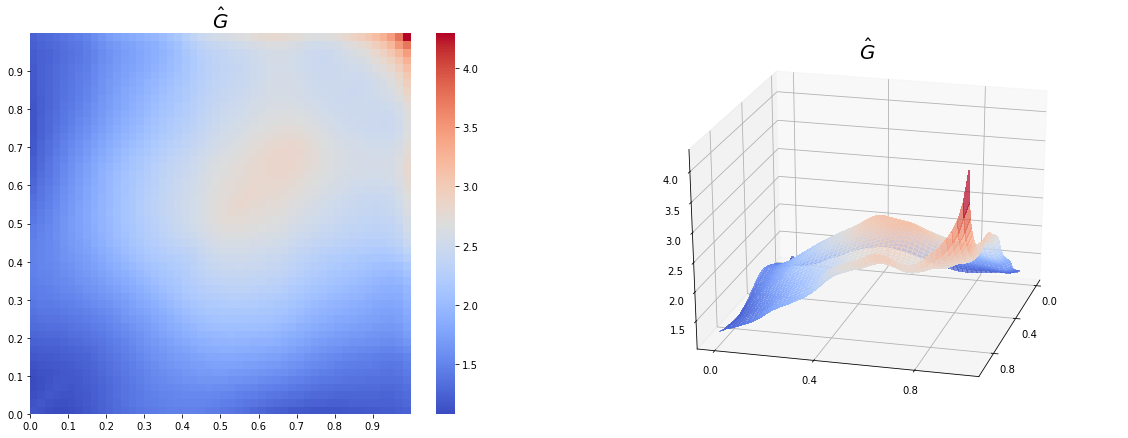

In [176]:
#plot 

# heatmap 
fig = plt.figure(figsize = (20,7))
axr = fig.add_subplot(1, 2, 1)


# grid discretisation of _hat for plotting

xx, yy = np.meshgrid(np.arange(N), np.arange(N))
Z_GHAT = np.array([GHAT[s,t] for s,t in zip(np.ravel(xx), np.ravel(yy))]).reshape(xx.shape)

axr.set_title('$\hat G$', fontsize=20)

sns.heatmap(Z_GHAT, 
            cmap='coolwarm', 
            annot=False, 
            fmt=".1f", 
            annot_kws={'size':16},
            ax = axr,
#             cbar=True, cbar_kws = dict(use_gridspec=False,location="top"),
            square=True)


axr.set_yticks(np.arange(N)[::5])
axr.set_xticks(np.arange(N)[::5])
axr.set_yticklabels(time_grid[::5].round(1), rotation = 0)
axr.set_xticklabels(time_grid[::5].round(1), rotation = 0)

axr.invert_yaxis()


# -------- # -------- # -------- # -------- # -------- # -------- # -------- 



# 3D plot 


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('$\hat G$', fontsize=20)

ax.azim = 15
ax.dist = 10
ax.elev = 25
ax.set_yticks(np.arange(N)[::20])
ax.set_xticks(np.arange(N)[::20])
ax.set_yticklabels(time_grid[::20].round(1), rotation = 0)
ax.set_xticklabels(time_grid[::20].round(1), rotation = 0)

surf2 = ax.plot_surface(xx, yy, Z_GHAT, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = .7)

# fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


# -------------- # -------------- # -------------- # -------------- 
# -------------- # -------------- # -------------- # -------------- 


#### Partial derivatives, $ D_1 G, D_2G$  

[Text(0, 0, '0.0'), Text(0, 0, '0.5')]

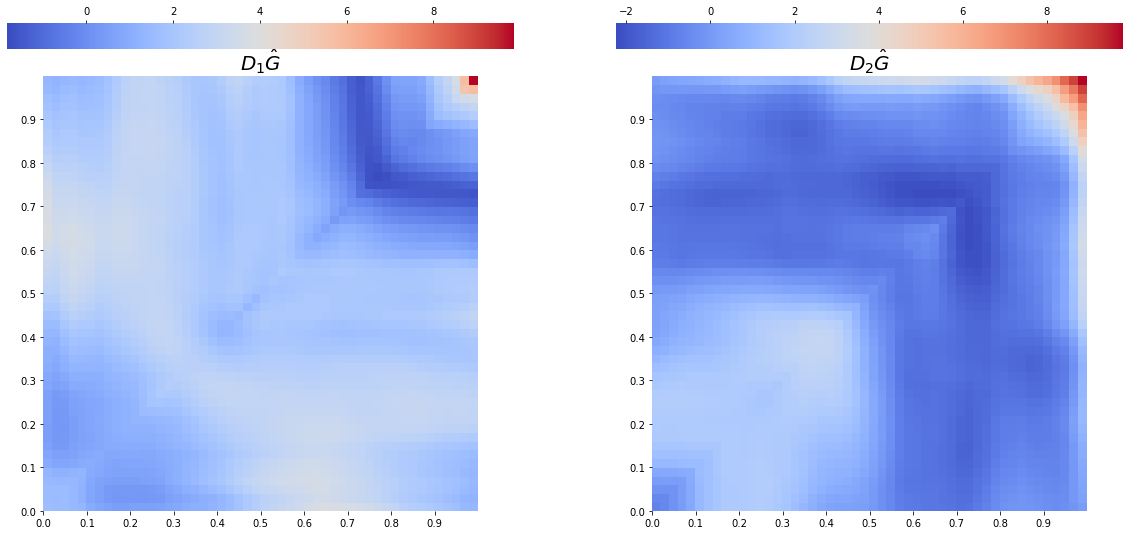

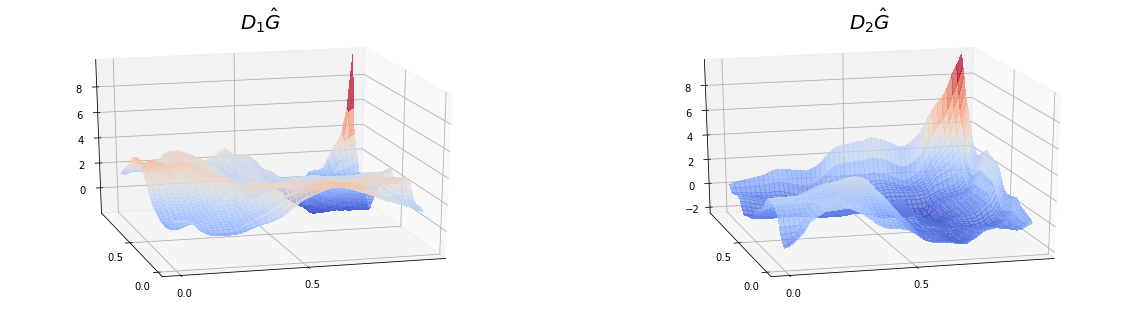

In [177]:
# plot 

# heatmap 

# --------------------------- D1 --------------------------- #

fig, [axl, axr]  = plt.subplots(figsize = (20,10), ncols = 2)

# grid discretisation of G and G_hat for plotting

xx, yy = np.meshgrid(np.arange(N), np.arange(N))
Z_D1_GHAT = np.array([D1GHAT[s,t] for s,t in zip(np.ravel(xx), np.ravel(yy))]).reshape(xx.shape)
Z_D2_GHAT = np.array([D2GHAT[s,t] for s,t in zip(np.ravel(xx), np.ravel(yy))]).reshape(xx.shape)


# fig.suptitle('heatmap of $G$ vs $\hat G$ ', fontsize=36)

axl.set_title('$D_1 \hat G$', fontsize=20)


sns.heatmap(Z_D1_GHAT, 
            cmap='coolwarm', 
            annot=False, 
            fmt=".1f", 
            annot_kws={'size':16},
            ax = axl,
            cbar=True, cbar_kws = dict(use_gridspec=False,location="top"),
            square=True)


axl.set_yticks(np.arange(N)[::5])
axl.set_xticks(np.arange(N)[::5])
axl.set_yticklabels(time_grid[::5].round(1), rotation = 0)
axl.set_xticklabels(time_grid[::5].round(1), rotation = 0)
axl.invert_yaxis()

# -------- # -------- # -------- # -------- # -------- # -------- # -------- 

axr.set_title('$D_2 \hat G$', fontsize=20)

sns.heatmap(Z_D2_GHAT, 
            cmap='coolwarm', 
            annot=False, 
            fmt=".1f", 
            annot_kws={'size':16},
            ax = axr,
            cbar=True, cbar_kws = dict(use_gridspec=False,location="top"),
            square=True)

            


axr.set_yticks(np.arange(N)[::5])
axr.set_xticks(np.arange(N)[::5])
axr.set_yticklabels(time_grid[::5].round(1), rotation = 0)
axr.set_xticklabels(time_grid[::5].round(1), rotation = 0)

axr.invert_yaxis()

# -------- # -------- # -------- # -------- # -------- # -------- # -------- 




# -------- # -------- # -------- # -------- # -------- # -------- # -------- 

# -------- # -------- # -------- # -------- # -------- # -------- # -------- 

# -------- # -------- # -------- # -------- # -------- # -------- # -------- 




# 3D plot 
fig = plt.figure(figsize = (20,5.5))



# -------------- # -------------- # -------------- # -------------- 

ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.set_title('$D_1\hat G$', fontsize=20)
ax.azim = -105
ax.dist = 10
ax.elev = 20
surf = ax.plot_surface(xx, yy, Z_D1_GHAT, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = .7)
ax.set_yticks(np.arange(N)[::25])
ax.set_xticks(np.arange(N)[::25])
ax.set_yticklabels(time_grid[::25].round(1), rotation = 0)
ax.set_xticklabels(time_grid[::25].round(1), rotation = 0)



# -------------- # -------------- # -------------- # -------------- 



# -------------- # -------------- # -------------- # -------------- 

ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.set_title('$D_2\hat G$', fontsize=20)
ax.azim = -105
ax.dist = 10
ax.elev = 20
surf = ax.plot_surface(xx, yy, Z_D2_GHAT, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha = .7)
# fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_yticks(np.arange(N)[::25])
ax.set_xticks(np.arange(N)[::25])
ax.set_yticklabels(time_grid[::25].round(1), rotation = 0)
ax.set_xticklabels(time_grid[::25].round(1), rotation = 0)


# -------------- # -------------- # -------------- # -------------- 
# -------------- # -------------- # -------------- # -------------- 



---

In [178]:
eval_start_ix = 0; eval_end_ix = N
# eval_start_ix = np.argmin((time_grid -.15)**2); eval_end_ix = np.argmin((time_grid -.85)**2)

## Drift

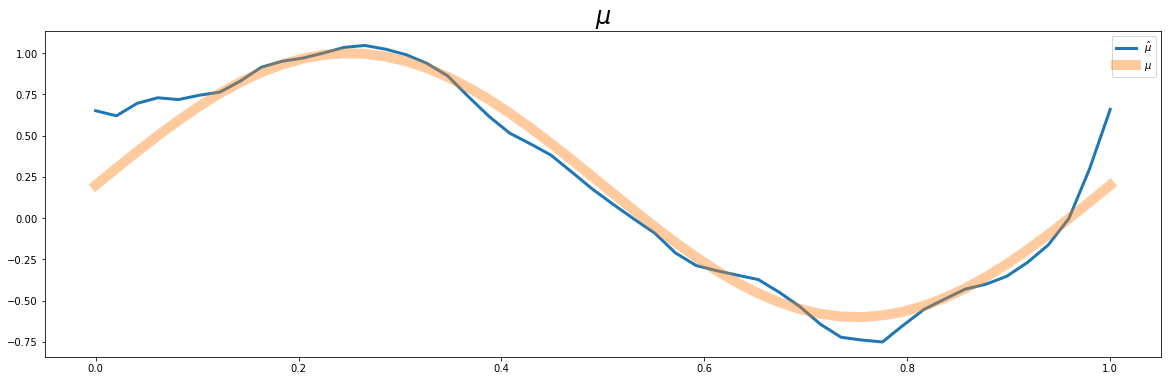

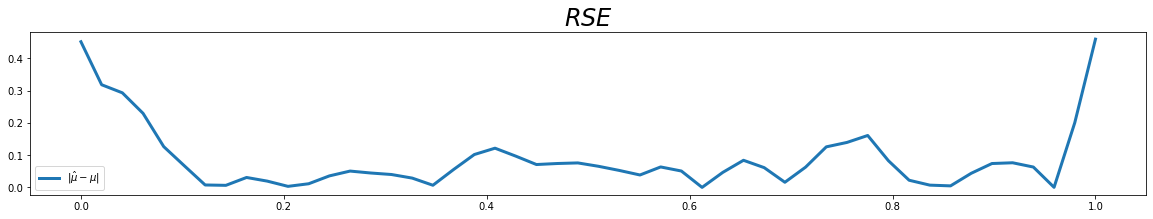

RMSE:     0.13


In [179]:
# mu -- DRIFT
mu_hat =  get_mu(m_hat,dm_hat)
MUHAT = dMHAT/MHAT
MU = np.array([mu(t) for t in time_grid])

# plot, drift estimation 
fig, ax = plt.subplots( figsize = (20,6), ncols=1)


ax.set_title("$\mu$", fontsize=24)

ax.plot(time_grid[eval_start_ix:eval_end_ix], 
         MUHAT[eval_start_ix:eval_end_ix],
         label ='$\hat \mu$', lw=3)

ax.plot(time_grid[eval_start_ix:eval_end_ix],
         MU[eval_start_ix:eval_end_ix],
         label ='$\mu$', lw=10, alpha=0.4)
ax.legend()

plt.show()

fig, ax = plt.subplots( figsize = (20,3), ncols=1)

ax.set_title("$RSE$", fontsize=24)
ax.plot(time_grid[eval_start_ix:eval_end_ix], 
         np.abs(MU-MUHAT)[eval_start_ix:eval_end_ix],
         label ='$|\hat \mu - \mu|$', lw=3)
ax.legend()
plt.show()

print('RMSE:     {:.2f}' .format(((MU-MUHAT)**2)[eval_start_ix:eval_end_ix].mean()**.5))

----

## Diffusion

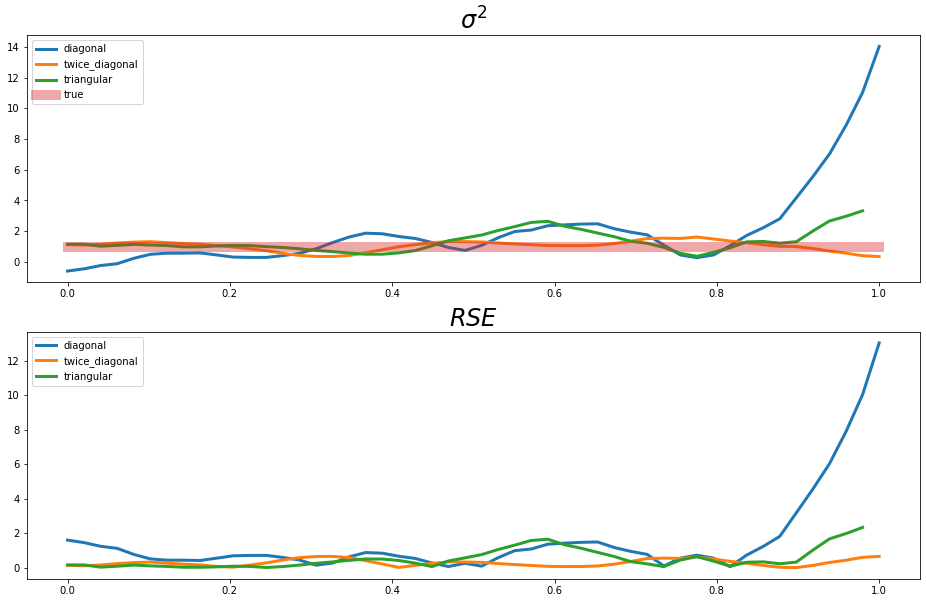

RMSE diagonal:                 1.25
RMSE twice_diagonal:           0.53
RMSE triangular:               0.72


In [180]:
# sigma -- DIFFUSION 

SIGMA = np.array([sigma(t) for t in time_grid])

SIGMASQUAREDHAT_triangular = np.array([
    get_sigma2_TRIANGULAR(MHAT, dMHAT, GHAT, D1GHAT, MUHAT)(t) for t in time_grid[:-1]])


SIGMASQUAREDHAT_diagonal = np.array([
    get_sigma2_DIAGONAL_fromFull(MHAT, dMHAT, GHAT, D1GHAT, D2GHAT, MUHAT)(t)  for t in time_grid])


SIGMASQUAREDHAT_twicediagonal = np.array([
    get_sigma2_DIAGONAL_fromDiag(MHAT, dMHAT, diag_GHAT, diag_dGHAT, MUHAT)(t) for t in time_grid])

# plot, diffusion estimation 


fig, [axU, axL]  = plt.subplots(figsize=(16,10), nrows=2)

# fig.suptitle('$C^2$', fontsize=24)
axU.set_title('$\sigma^2$', fontsize=24)


axU.plot(time_grid[eval_start_ix:eval_end_ix], 
         SIGMASQUAREDHAT_diagonal[eval_start_ix:eval_end_ix],
         label ='diagonal', lw=3)

axU.plot(time_grid[eval_start_ix:eval_end_ix], 
         SIGMASQUAREDHAT_twicediagonal[eval_start_ix:eval_end_ix],
         label ='twice_diagonal', lw=3)

axU.plot(time_grid[:-1][eval_start_ix:eval_end_ix], 
         SIGMASQUAREDHAT_triangular[eval_start_ix:eval_end_ix], label ='triangular' , lw=3)


axU.plot(time_grid[eval_start_ix:eval_end_ix],
        ( SIGMA**2)[eval_start_ix:eval_end_ix],
         label ='true', lw=10, alpha=0.4)


axU.legend()
# ------- # ------- # ------- # ------- # ------- # ------- # ------- # ------- # ------- 


axL.set_title('$RSE$', fontsize=24)


axL.plot(time_grid[eval_start_ix:eval_end_ix], 
         np.abs(SIGMASQUAREDHAT_diagonal - SIGMA**2)[eval_start_ix:eval_end_ix],
         label ='diagonal', lw=3)

axL.plot(time_grid[eval_start_ix:eval_end_ix], 
         np.abs(SIGMASQUAREDHAT_twicediagonal - SIGMA**2)[eval_start_ix:eval_end_ix],
         label ='twice_diagonal', lw=3)

axL.plot(time_grid[:-1][eval_start_ix:eval_end_ix], 
         np.abs(SIGMASQUAREDHAT_triangular- SIGMA[:-1]**2)[eval_start_ix:eval_end_ix], label ='triangular' , lw=3)



axL.legend()

plt.show()

print('RMSE diagonal:                 {:.2f}'.format(
    np.abs(SIGMASQUAREDHAT_diagonal - SIGMA**2)[eval_start_ix:eval_end_ix].mean()**.5))
print('RMSE twice_diagonal:           {:.2f}'.format(
    np.abs(SIGMASQUAREDHAT_twicediagonal - SIGMA**2)[eval_start_ix:eval_end_ix].mean()**.5))
print('RMSE triangular:               {:.2f}'.format(
    np.abs(SIGMASQUAREDHAT_triangular - SIGMA[:-1]**2)[eval_start_ix:eval_end_ix].mean()**.5))


---

---

---

---

---

---

---

---

---

---

---

---

---

---

---

In [ ]:
#plot
time_grid= np.linspace(0,1,100)
SIGMA = np.array([sigma(t) for t in time_grid])
MU = np.array([mu(t) for t in time_grid])


fig, [axL,axR] = plt.subplots(figsize = (10,8), nrows = 2)
fig.tight_layout(pad=3.0)
axL.plot(time_grid, [mu(t) for t in time_grid], c='r')
axL.set_title('$\mu(t)$', fontsize = 20)
# axL.set_yticks(MU)
# axL.set_yticklabels([2])
axR.plot(time_grid, [sigma(t) for t in time_grid], c='r')
axR.set_yticks(SIGMA)
axR.set_yticklabels([1])
axR.set_title('$\sigma(t)$', fontsize = 20)
plt.show()


---

---

---

---

---

---

---

In [ ]:
#plot
fig = plt.figure(figsize = (12,4))


# 3D plot 


xx, yy = np.meshgrid(time_grid, time_grid)
Z_G = np.array([G(min(s,t), max(s,t)) for s,t in zip(np.ravel(xx), np.ravel(yy))]).reshape(xx.shape)

ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.set_title('$G$', fontsize=20)
ax.azim = 15
ax.dist = 10
ax.elev = 25


surf = ax.plot_surface(xx, yy, Z_G, cmap=cm.coolwarm,vmin =low, vmax = up,#norm=LogNorm(vmin=low, vmax=up),
                       linewidth=0, antialiased=False, alpha = .7)

# -------------- # -------------- # -------------- # -------------- 



xx, yy = np.meshgrid(time_grid, time_grid)
Z_D1_G = np.array([D1_G(min(s,t), max(s,t)) for s,t in zip(np.ravel(xx), np.ravel(yy))]).reshape(xx.shape)



ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_title('$\partial_sG$', fontsize=20)
ax.azim = -105
ax.dist = 10
ax.elev = 20
ax.set_zlim3d(minZ, maxZ)
surf = ax.plot_surface(xx, yy, Z_D1_G, cmap=cm.coolwarm,vmin =low, vmax = up,#norm=LogNorm(vmin=low, vmax=up),
                       linewidth=0, antialiased=False, alpha = .7)



# -------------- # -------------- # -------------- # -------------- 


xx, yy = np.meshgrid(time_grid, time_grid)
Z_D2_G = np.array([D2_G(min(s,t), max(s,t)) for s,t in zip(np.ravel(xx), np.ravel(yy))]).reshape(xx.shape)

ax = fig.add_subplot(1, 3, 3, projection='3d')
ax.set_title('$\partial_tG$', fontsize=20)
ax.azim = -105
ax.dist = 10
ax.elev = 20



surf = ax.plot_surface(xx, yy, Z_D2_G, cmap=cm.coolwarm,#vmin =low, vmax = up,
                       linewidth=0, antialiased=False, alpha = .7)
fig.tight_layout(pad=.5)

# -------------- # -------------- # -------------- # -------------- 
plt.show()

---

In [ ]:
#plot
time_grid= np.linspace(0,1,100)
SIGMA = np.array([sigma(t) for t in time_grid])
MU = np.array([mu(t) for t in time_grid])


fig, [axL,axR] = plt.subplots(figsize = (5,4), nrows = 2)
fig.tight_layout(pad=3.0)
axL.plot(time_grid, [mu(t) for t in time_grid], c='r')
axL.set_title('$\mu(t)$', fontsize = 20)
# axL.set_yticks(MU)
# axL.set_yticklabels([2])
axR.plot(time_grid, [sigma(t) for t in time_grid], c='r')
axR.set_yticks(SIGMA)
axR.set_yticklabels(np.round([1.41],2))
axR.set_title('$\sigma(t)$', fontsize = 20)
plt.show()


---